In [179]:
### Reloads modulesproperly
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

os.sys.path.append("../")

In [3]:
import numpy as np

In [4]:
import pandas as pd

# Show all the columns and rows in pandas df
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)

In [5]:
import matplotlib.pyplot as plt

In [6]:
import mplhep

mplhep.style.use("CMS")

In [7]:
import uproot

In [185]:
from statsmodels.stats.proportion import proportion_confint

# Full Data set optimization results

In [9]:
!ls -lh ../

total 111M
-rw-r--r-- 1 lborgna users 8.9K Nov 10 15:48 analysis.py
-rw-r--r-- 1 lborgna users  921 Nov 11 14:53 convert_root_to_pickle.py
-rw-r--r-- 1 lborgna users  70M Nov 12 01:31 dbscan_all_events_optimization.pkl
-rw-r--r-- 1 lborgna users 2.0K Nov 11 15:38 dbscan_optimization.py
-rw-r--r-- 1 lborgna users  40M Nov 11 17:14 fastHisto_all_events_optimization.pkl
-rw-r--r-- 1 lborgna users 1.7K Nov 11 15:47 fasthisto_optimization.py
-rw-r--r-- 1 lborgna users 3.2K Nov 10 15:48 histograms.py
-rw-r--r-- 1 lborgna users 637K Nov 10 15:48 L1TriggerInputData.png
drwxr-xr-x 3 lborgna users 4.0K Nov 12 14:40 notebooks
-rw-r--r-- 1 lborgna users 6.8K Nov 10 15:48 README.md
-rw-r--r-- 1 lborgna users 108K Nov 10 15:48 residuals.png
-rw-r--r-- 1 lborgna users 376K Nov 10 15:48 TrackParameters.png
-rw-r--r-- 1 lborgna users 252K Nov 10 15:48 TracksPerPhiSector.png


In [10]:
dbscan_results = pd.read_pickle('../dbscan_all_events_optimization.pkl')

In [23]:
dbscan_results.shape

(952812, 10)

In [12]:
histo_results = pd.read_pickle('../fastHisto_all_events_optimization.pkl')

In [21]:
histo_results.shape

(952812, 9)

# Primary Vertex Efficiency

In [14]:
def primary_vertex_efficiency(
    z0_gen: np.array, z0_reco: np.array, delta: float = 0.1
) -> pd.DataFrame:
    mask = np.abs(z0_gen - z0_reco) < delta

    total = z0_gen.shape[0]

    reconstructed = z0_gen[mask].shape[0]

    return 100 * (reconstructed / total)

## Fast Histo primary Vertex Efficiency versus bin width

In [15]:
bin_widths = [0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35]


In [16]:
eff = np.zeros(len(bin_widths))
for i, bin_width in enumerate(bin_widths):
    eff[i] = primary_vertex_efficiency(
        histo_results["z0_gen"], histo_results[f"z0_fastHisto_{bin_width}"]
    )
    

Text(0, 1, 'Efficiency [%]')

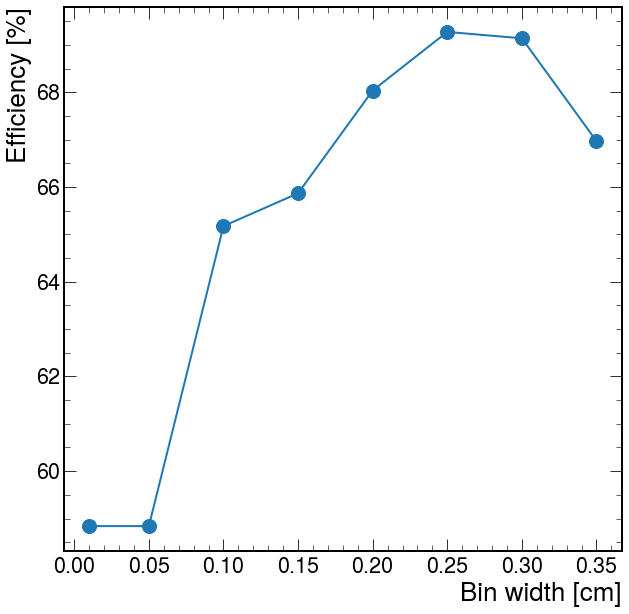

In [41]:
plt.plot(bin_widths, eff, 'o-', lw =2 , ms=14)
plt.xlabel('Bin width [cm]')
plt.ylabel('Efficiency [%]')

## DBSCAN Efficiency vs eps

In [28]:
eps_values = [0.01, 0.03, 0.05, 0.06, 0.08, 0.1, 0.15, 0.20, 0.25]

In [30]:
eff_db = np.zeros(len(eps_values))
for i, eps in enumerate(eps_values):
    eff_db[i] = primary_vertex_efficiency(
        dbscan_results["z0_gen"], dbscan_results[f"z0_dbscan_e{eps}_min_2"]
    )
    

In [31]:
eff_db

array([ 1.98412698,  1.98412698,  1.98412698, 74.55248255, 74.55248255,
       74.55248255, 69.79351645, 54.36392489, 42.85630324])

Text(0, 1, 'Efficiency [%]')

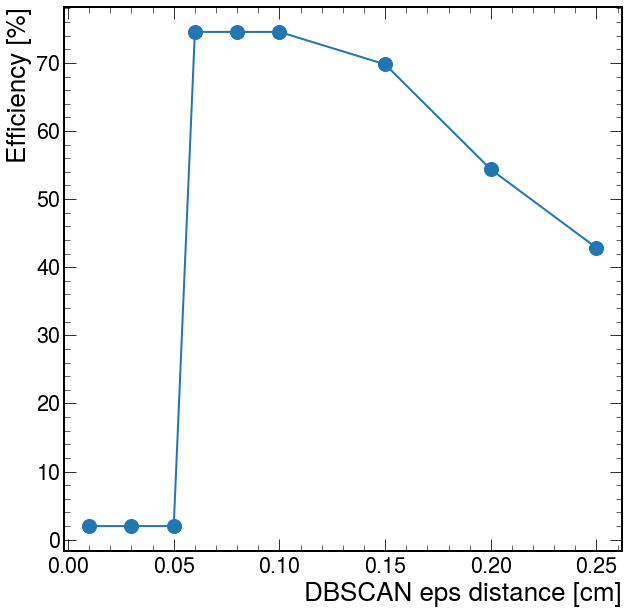

In [39]:
plt.plot(eps_values, eff_db,'o-', lw = 2, ms=14)
plt.xlabel('DBSCAN eps distance [cm]')
plt.ylabel('Efficiency [%]')

# Primary Vertex Efficiency as a function of $z_{0}$

In [53]:
def binominal_error(k, n):
    yerr = (1 / n) * np.sqrt(k * (1 - (k / n)))
    return yerr

In [76]:
def poisson_error(k, n):

    yerr = (1 / n) * np.sqrt(k)

    return yerr

In [54]:
def bin_width_error(bin_edges):
    """
    Determines the horizontal (x) error of a bin  by calculating half the bin size
    :param bin_edges:
    :return: xerr array containing the absolute magnitude of the error in x
    """
    # determines the error in a bin by +/- half of the bin_width
    xerr = []
    for k in range(len(bin_edges)):
        if k != (len(bin_edges) - 1):
            x1 = bin_edges[k]
            x2 = bin_edges[k + 1]
            bin_error = (x2 - x1) / 2
            xerr.append(bin_error)
    xerr = np.asarray(xerr)
    return xerr

In [251]:
proportion_confint([100, 90], [150, 140], method='beta')

(array([0.58515699, 0.55754551]), array([0.74144364, 0.72198406]))

In [255]:
90/140

0.6428571428571429

In [256]:
proportion_confint([90], [140], method='beta')

(array([0.58515699]), array([0.74144364]))

In [245]:
def pv_efficiency_z0(
    z0_gen: np.array, z0_reco: np.array, bins: np.array, error_type: str = "clopper"
):

    eff = np.zeros(bins.shape[0] - 1)
    if error_type == "clopper":
        error_y = np.zeros((bins.shape[0] - 1, 2))
    else:
        error_y = np.zeros(bins.shape[0] - 1)

    for i, _ in enumerate(bins):
        if i == bins.shape[0] - 1:
            break
        mask = (z0_gen > bins[i]) & (z0_gen < bins[i + 1])
        mask_true = np.abs(z0_gen - z0_reco) < 0.1
        n = z0_gen[mask].shape[0]

        k = z0_gen[mask & mask_true].shape[0]
        eff[i] = k / (n)
        if error_type == "clopper":
            ci_low, ci_upp = proportion_confint(k, n, method="beta")
            error_y[i, 0] = ci_low
            error_y[i, 1] = ci_upp
        else:
            error_y[i] = binominal_error(k, (n + 0.0001))

    x = 0.5 * (bins[1:] + bins[:-1])
    error_x = 0.5 * (bins[1:] - bins[:-1])

    return {"x": x, "error_x": error_x, "eff": 100 * eff, "error_y": error_y}

In [246]:
start, stop, step = -15, 15, 1.0
be_eff = np.arange(start, stop + step, step)

In [247]:
statsmodels.stats

<module 'statsmodels.stats' from '/mnt/storage/lborgna/condaenv/db-clustering/lib/python3.8/site-packages/statsmodels/stats/__init__.py'>

ZeroDivisionError: division by zero

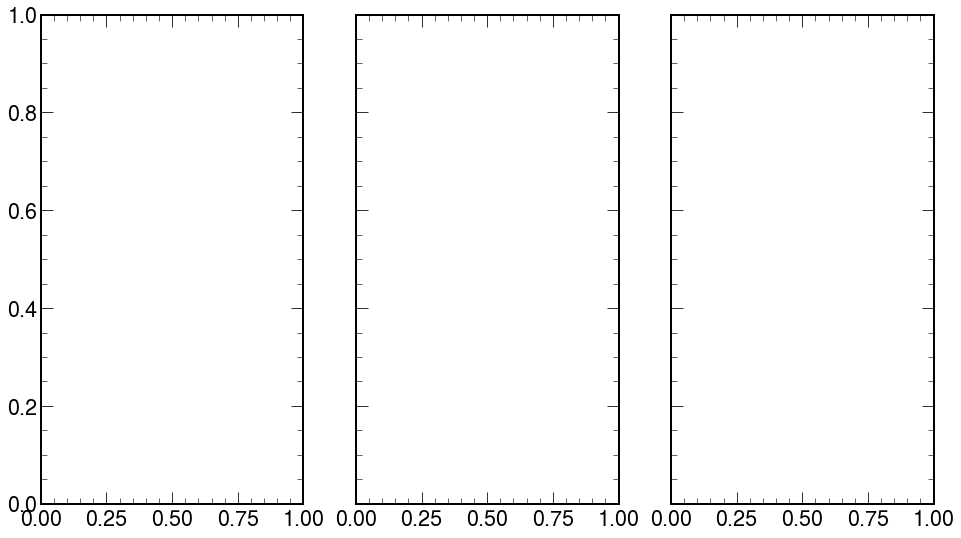

In [248]:
dbscan_eff_z0 = np.zeros((len(eps_values), len(be_eff) - 1))
fig, ax = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
j = 0
errory_dbscan = np.zeros((len(eps_values), len(be_eff) - 1))
for i, eps in enumerate(eps_values):
    if (eps > 0.06) and (eps <= 0.15):

        _results = pv_efficiency_z0(
            dbscan_results["z0_gen"],
            dbscan_results[f"z0_dbscan_e{eps}_min_2"],
            be_eff,
            error_type="binomial",
        )

        dbscan_eff_z0[i] = _results["eff"]
        errory_dbscan[i] = _results["error_y"]
        ax[j].plot(
            _results["x"],
            _results["eff"],
            #             xerr=_results["error_x"],
            #             yerr=100*_results["error_y"],
            lw=2,
            label=f"DBSCAN eps = {eps}",
        )
        ax[j].set_xlim(-10, 10)
        ax[j].set_title(f"DBSCAN eps = {eps}")
        j += 1
plt.subplots_adjust(wspace=0)

In [ ]:
dbscan_results.reset_index()

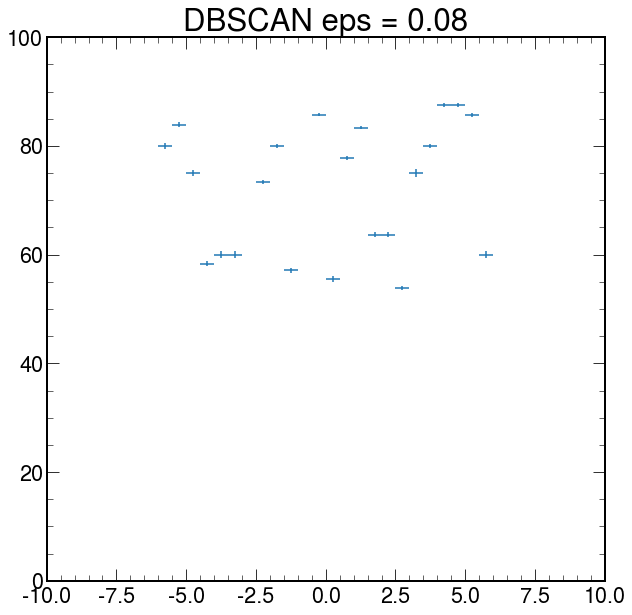

In [250]:
start, stop, step = -6, 6, 0.5
be_eff = np.arange(start, stop + step, step)
_results = pv_efficiency_z0(
    dbscan_results["z0_gen"], dbscan_results[f"z0_dbscan_e0.08_min_2"], be_eff,error_type= 'clopper'
)

lower_error = _results['eff'] - 100 * _results['error_y'][:,0]
upper_error = 100 * _results['error_y'][:, 1] - _results['eff']

plt.errorbar(
    _results["x"],
    _results["eff"],
            xerr=_results["error_x"],
            yerr=[lower_error, upper_error],
    ls='none',
    label=f"DBSCAN eps = 0.08",
)
plt.xlim(-10, 10)
plt.ylim(0, 100)
plt.title(f'DBSCAN eps = 0.08')
j+=1
plt.subplots_adjust(wspace=0)

In [249]:
lower_error

array([0.01951082, 0.01393668, 0.01219471, 0.00812997, 0.01951082,
       0.01951082, 0.01393668, 0.00650403, 0.00975588, 0.00696859,
       0.00886902, 0.00696859, 0.01083981, 0.01083981, 0.00542005,
       0.00886902, 0.00886902, 0.00750461, 0.02438792, 0.00975588,
       0.01219471, 0.01219471, 0.01393668, 0.01951082])

In [216]:
upper_error

array([           nan,            nan,            nan, 1.13336709e+00,
                  nan,            nan, 8.67557093e-01, 8.67557093e-01,
       4.40800491e-07, 3.50357280e-01, 3.40034758e-01, 4.94338020e-01,
       2.61594301e-01, 3.06743299e-01, 1.72185711e-01, 3.54180369e-01,
       2.53053741e-01, 3.21049083e-01, 3.48921276e-01, 2.62561779e-01,
       3.97925316e-01, 6.88551683e-01, 8.81600968e-07, 8.76118327e-01,
       2.64480290e-06, 2.64480290e-06,            nan,            nan,
                  nan,            nan])

In [195]:
_results[
    'eff'
]

array([ 0.        ,  0.        ,  0.        , 49.99999934,  0.        ,
        0.        , 66.66666608, 66.66666608, 99.99999956, 82.28202397,
       64.99999991, 59.99999984, 81.81818172, 66.66005459, 91.9999999 ,
       66.66666657, 75.8620689 , 58.33333327, 78.57142842, 87.49999986,
       74.99999983, 74.9999995 , 99.99999912, 33.33333304, 99.99999736,
       99.99999736,  0.        ,  0.        ,  0.        ,  0.        ])

In [203]:
lower_error = _results['eff'] - 100 * _results['error_y'][:,0] 

In [204]:
lower_error

array([       nan,        nan,        nan, 1.13336577,        nan,
              nan, 0.87611745, 0.87611745, 0.01625884, 0.35449248,
       0.34118576, 0.49587405, 0.26381502, 0.30780842, 0.17476794,
       0.35560161, 0.25442216, 0.32158174, 0.35205652, 0.26616453,
       0.4011261 , 0.69817904, 0.03251503, 0.86755621, 0.09751337,
       0.09751337,        nan,        nan,        nan,        nan])

In [205]:
upper_error = 100 * _results['error_y'][:,1] - _results['eff']

In [209]:
_results['eff']/100

array([0.        , 0.        , 0.        , 0.49999999, 0.        ,
       0.        , 0.66666666, 0.66666666, 1.        , 0.82282024,
       0.65      , 0.6       , 0.81818182, 0.66660055, 0.92      ,
       0.66666667, 0.75862069, 0.58333333, 0.78571428, 0.875     ,
       0.75      , 0.75      , 0.99999999, 0.33333333, 0.99999997,
       0.99999997, 0.        , 0.        , 0.        , 0.        ])

In [212]:
100 * 0.49999999 -  100 *0.48866634

1.1333650000000048

In [213]:
100 * 0.51133366 - 100 * 0.49999999

1.1333669999999998

In [207]:
_results['error_y']

array([[       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [0.48866634, 0.51133366],
       [       nan,        nan],
       [       nan,        nan],
       [0.65790549, 0.67534223],
       [0.65790549, 0.67534223],
       [0.99983741, 1.        ],
       [0.81927531, 0.82632381],
       [0.64658814, 0.65340035],
       [0.59504126, 0.60494338],
       [0.81554367, 0.82079776],
       [0.66352246, 0.66966798],
       [0.91825232, 0.92172186],
       [0.66311065, 0.67020847],
       [0.75607647, 0.76115123],
       [0.58011752, 0.58654382],
       [0.78219372, 0.7892035 ],
       [0.87233835, 0.87762562],
       [0.74598874, 0.75397925],
       [0.7430182 , 0.75688551],
       [0.99967484, 1.        ],
       [0.32465777, 0.34209451],
       [0.99902484, 1.        ],
       [0.99902484, 1.        ],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan]])

In [200]:
[lower_error, upper_error]

[array([       nan,        nan,        nan, 0.48866634,        nan,
               nan, 0.65790549, 0.65790549, 0.99983741, 0.81927531,
        0.64658814, 0.59504126, 0.81554367, 0.66352246, 0.91825232,
        0.66311065, 0.75607647, 0.58011752, 0.78219372, 0.87233835,
        0.74598874, 0.7430182 , 0.99967484, 0.32465777, 0.99902484,
        0.99902484,        nan,        nan,        nan,        nan]),
 array([       nan,        nan,        nan, 0.51133366,        nan,
               nan, 0.67534223, 0.67534223, 1.        , 0.82632381,
        0.65340035, 0.60494338, 0.82079776, 0.66966798, 0.92172186,
        0.67020847, 0.76115123, 0.58654382, 0.7892035 , 0.87762562,
        0.75397925, 0.75688551, 1.        , 0.34209451, 1.        ,
        1.        ,        nan,        nan,        nan,        nan])]

In [196]:
_results['error_y'] * 100

array([[         nan,          nan],
       [         nan,          nan],
       [         nan,          nan],
       [ 48.86663357,  51.13336643],
       [         nan,          nan],
       [         nan,          nan],
       [ 65.79054863,  67.53422317],
       [ 65.79054863,  67.53422317],
       [ 99.98374072, 100.        ],
       [ 81.92753149,  82.63238125],
       [ 64.65881416,  65.34003467],
       [ 59.50412579,  60.49433786],
       [ 81.5543667 ,  82.07977602],
       [ 66.35224616,  66.96679788],
       [ 91.82523197,  92.17218561],
       [ 66.31106496,  67.02084694],
       [ 75.60764674,  76.11512264],
       [ 58.01175152,  58.65438235],
       [ 78.2193719 ,  78.9203497 ],
       [ 87.23383532,  87.76256163],
       [ 74.59887373,  75.39792515],
       [ 74.30182046,  75.68855119],
       [ 99.96748409, 100.        ],
       [ 32.46577683,  34.20945137],
       [ 99.90248398, 100.        ],
       [ 99.90248398, 100.        ],
       [         nan,          nan],
 

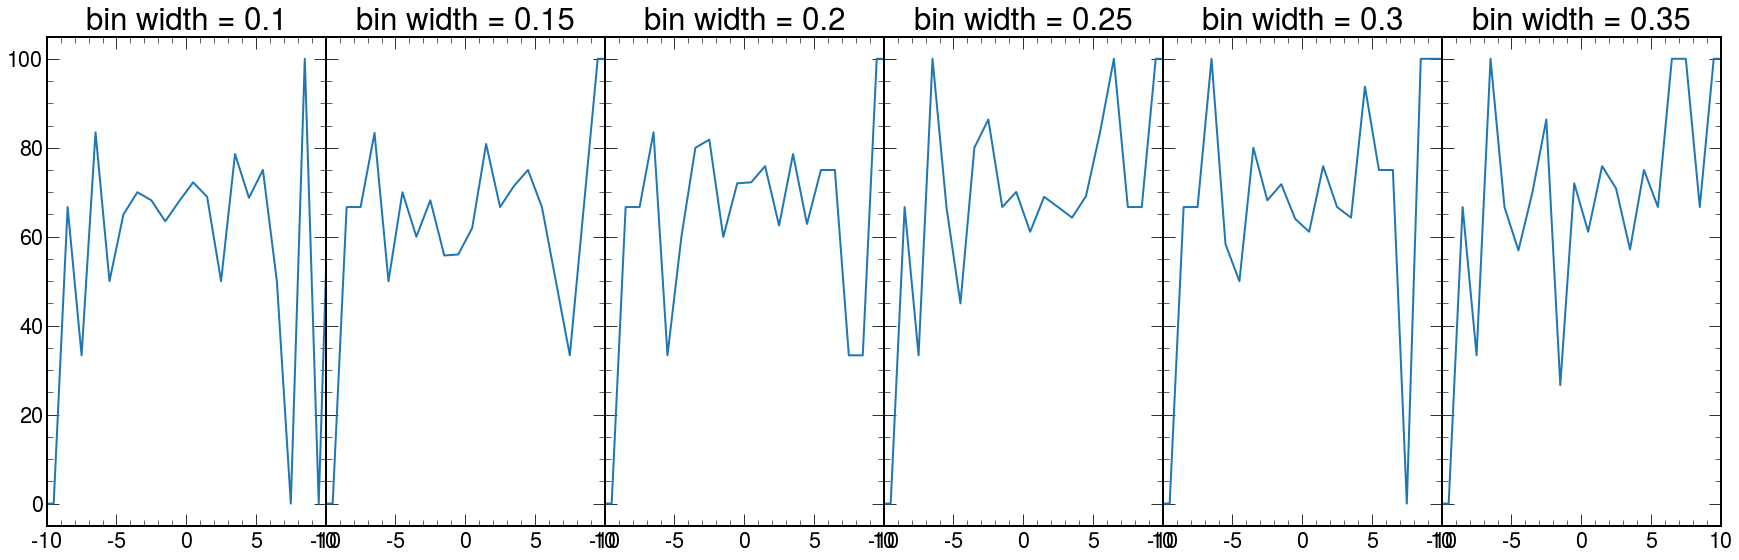

In [174]:
fastHist_eff_z0 = np.zeros((len(bin_widths), len(be_eff) - 1))
fig,ax = plt.subplots(1,6, figsize=(30,9),sharey=True)
j=0
errory_fastHist= np.zeros((len(bin_widths), len(be_eff) - 1))
for i, bw in enumerate(bin_widths):
    if (bw > 0.06):
        

        _results = pv_efficiency_z0(
            histo_results["z0_gen"], histo_results[f"z0_fastHisto_{bw}"], be_eff
        )

        fastHist_eff_z0[i] = _results["eff"]
        errory_fastHist[i] = _results['error_y']
        ax[j].plot(
            _results["x"],
            _results["eff"],
#             xerr=_results["error_x"],
#             yerr=100*_results["error_y"],
            lw=2,
            label=f"fastHisto bin with = {bw}",
        )
        ax[j].set_xlim(-10, 10)
        ax[j].set_title(f'bin width = {bw}')
        j+=1
plt.subplots_adjust(wspace=0)


In [175]:
histo_results

,z0_gen,z0_fastHisto_0.01,z0_fastHisto_0.05,z0_fastHisto_0.1,z0_fastHisto_0.15,z0_fastHisto_0.2,z0_fastHisto_0.25,z0_fastHisto_0.3,z0_fastHisto_0.35
0,3.499750,3.574219,3.574219,3.552246,3.507812,3.507812,3.601562,3.474609,3.662109
1,0.338214,0.292969,0.292969,0.253906,0.234375,0.267857,0.169271,0.191761,0.205078
2,-2.649157,-2.578125,-2.578125,-2.560547,-2.607422,-2.560547,-2.589844,-2.589844,-2.589844
3,1.543104,1.406250,1.406250,1.439732,1.582031,1.480824,1.628906,1.628906,1.582031
4,2.421834,2.343750,2.343750,2.343750,2.333984,2.333984,2.343750,2.333984,2.343750
...,...,...,...,...,...,...,...,...,...
952807,1.910414,1.933594,1.933594,1.933594,1.851562,1.851562,1.851562,1.851562,1.966146
952808,-2.066012,-2.050781,-2.050781,-2.050781,-2.024740,-2.091797,-2.130301,-1.964614,-2.153320
952809,-2.285170,-2.285156,-2.285156,-2.253906,-2.316406,-2.285156,-2.334498,-2.253906,-2.253906
952810,-4.809160,-4.746094,-4.746094,-4.848633,-4.712612,-4.702148,-4.702148,-4.921875,-4.722656


## Primary Vertex Efficiency vs $z_{0}$ for FastHisto and DBSCAN

Text(0.5, 1.0, 'FastHisto vs DBSCAN')

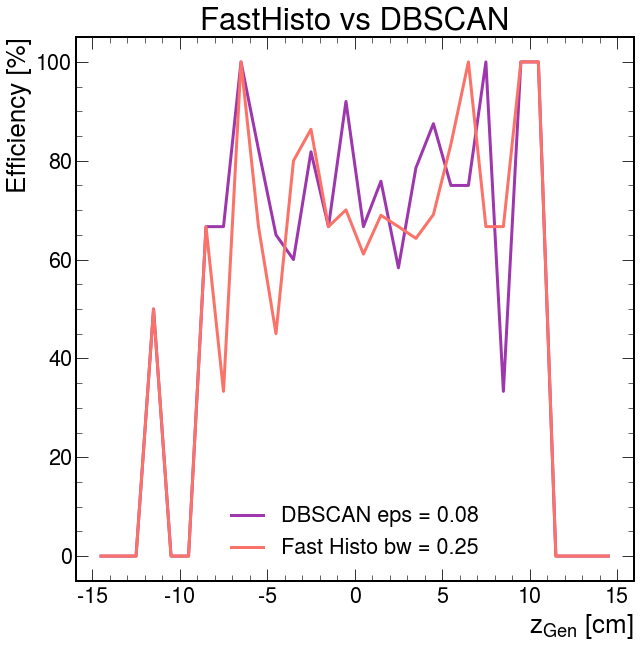

In [176]:
plt.plot(_results['x'], dbscan_eff_z0[4,:], label = 'DBSCAN eps = 0.08', color = "#9E37AD", lw =3)
plt.plot(_results['x'], fastHist_eff_z0[5,:], label = 'Fast Histo bw = 0.25', color = "#FA7268", lw = 3)
_results['error_y']
plt.legend()
plt.xlabel(r'$z_{Gen}$ [cm]')
plt.ylabel('Efficiency [%]')
plt.title('FastHisto vs DBSCAN')

Text(0.5, 1.0, 'FastHisto vs DBSCAN')

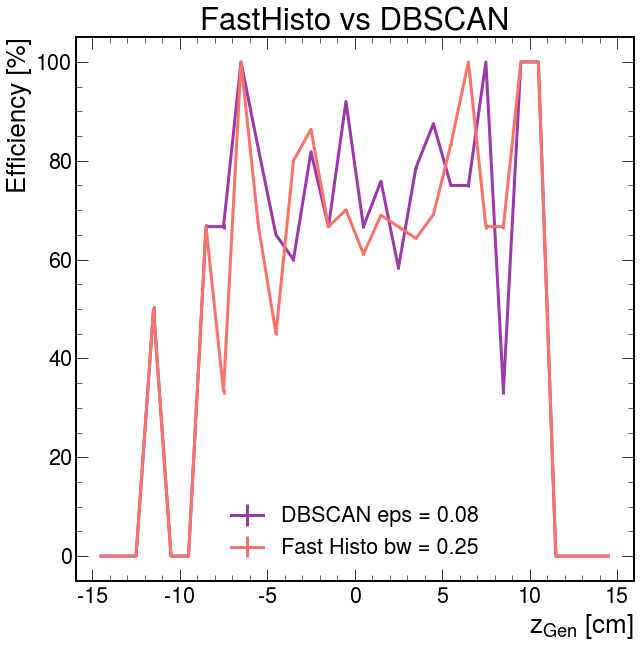

In [177]:
plt.errorbar(_results['x'], dbscan_eff_z0[4,:], yerr=100*errory_dbscan[4,:], label = 'DBSCAN eps = 0.08', color = "#9E37AD", lw =3)
plt.errorbar(_results['x'], fastHist_eff_z0[5,:],yerr=100*errory_fastHist[5,:], label = 'Fast Histo bw = 0.25', color = "#FA7268", lw = 3)
plt.legend()
plt.xlabel(r'$z_{Gen}$ [cm]')
plt.ylabel('Efficiency [%]')
plt.title('FastHisto vs DBSCAN')

In [178]:
dbscan_results.shape

(952812, 10)

# Resolution of FastHisto and DBSCAN

In [107]:
dbscan_results.head()

,z0_gen,z0_dbscan_e0.01_min_2,z0_dbscan_e0.03_min_2,z0_dbscan_e0.05_min_2,z0_dbscan_e0.06_min_2,z0_dbscan_e0.08_min_2,z0_dbscan_e0.1_min_2,z0_dbscan_e0.15_min_2,z0_dbscan_e0.2_min_2,z0_dbscan_e0.25_min_2
0,3.499750,0.029297,0.029297,0.029297,3.515625,3.515625,3.515625,3.457031,3.457031,3.457031
1,0.338214,-0.410156,-0.410156,-0.410156,0.205078,0.205078,0.205078,0.644531,0.644531,0.527344
2,-2.649157,-0.527344,-0.527344,-0.527344,-2.578125,-2.578125,-2.578125,-2.578125,-1.406250,-0.439453
3,1.543104,0.058594,0.058594,0.058594,1.464844,1.464844,1.464844,1.494141,1.406250,1.406250
4,2.421834,-0.820312,-0.820312,-0.820312,-3.750000,-3.750000,-3.750000,2.343750,-0.878906,-0.878906


In [109]:
resolution = pd.DataFrame({})
resolution['z0_gen'] = histo_results['z0_gen']
resolution['z0_fastHisto_0.25'] = histo_results['z0_fastHisto_0.25']
resolution['z0_dbscan_e0.08_min_2'] = dbscan_results['z0_dbscan_e0.08_min_2']

In [111]:
resolution['fasthisto'] = resolution['z0_gen'] - resolution['z0_fastHisto_0.25']
resolution['dbscan'] = resolution['z0_gen'] - resolution['z0_dbscan_e0.08_min_2']  

In [112]:
resolution


,z0_gen,z0_fastHisto_0.25,z0_dbscan_e0.08_min_2,fasthisto,dbscan
0,3.499750,3.601562,3.515625,-0.101812,-0.015875
1,0.338214,0.169271,0.205078,0.168943,0.133135
2,-2.649157,-2.589844,-2.578125,-0.059314,-0.071032
3,1.543104,1.628906,1.464844,-0.085802,0.078260
4,2.421834,2.343750,-3.750000,0.078084,6.171834
...,...,...,...,...,...
952807,1.910414,1.851562,-0.410156,0.058851,2.320570
952808,-2.066012,-2.130301,-2.050781,0.064289,-0.015231
952809,-2.285170,-2.334498,-2.285156,0.049329,-0.000014
952810,-4.809160,-4.702148,-4.863281,-0.107012,0.054121


In [113]:
import seaborn as sns

Text(0, 1, 'DBSCAN')

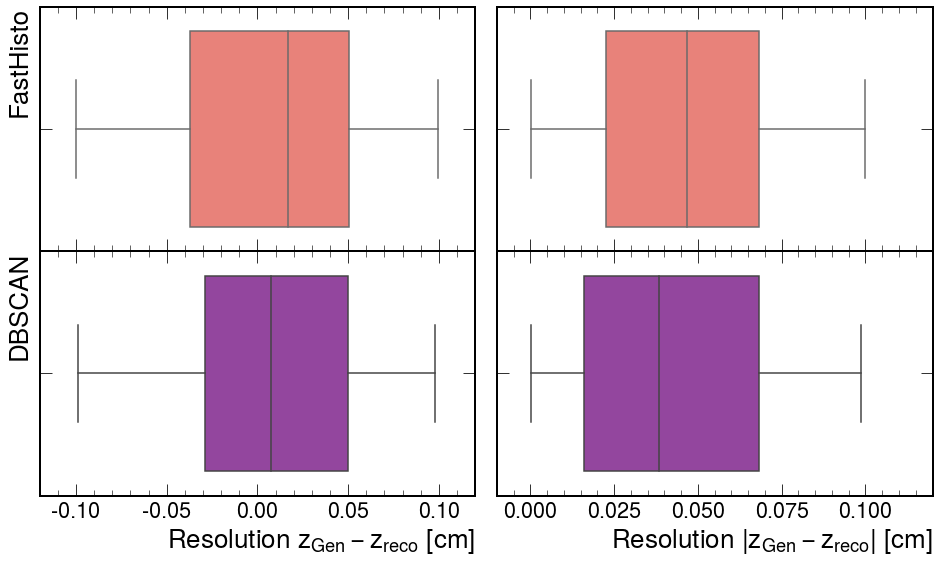

In [139]:
fig, ax = plt.subplots(2,2,figsize=(16,9))

sns.boxplot(x=resolution.loc[np.abs(resolution['fasthisto']) < 0.1, 'fasthisto'],ax=ax[0,0], color = '#FA7268')
sns.boxplot(x=resolution.loc[np.abs(resolution['dbscan'])< 0.1, 'dbscan'],ax=ax[1,0], color = "#9E37AD")
plt.subplots_adjust(hspace=0)
ax[1,0].set_xlabel(r'Resolution $z_{Gen} - z_{reco}$ [cm]')
sns.boxplot(x=np.abs(resolution.loc[np.abs(resolution['fasthisto']) < 0.1, 'fasthisto']),ax=ax[0,1], color = '#FA7268')
sns.boxplot(x=np.abs(resolution.loc[np.abs(resolution['dbscan'])< 0.1, 'dbscan']),ax=ax[1,1],color = "#9E37AD")
plt.subplots_adjust(hspace=0, wspace=0.05)
ax[1,0].set_xlabel(r'Resolution $z_{Gen} - z_{reco}$ [cm]')
ax[0,0].set_xlim(-0.12, 0.12)
ax[1,0].set_xlim(-0.12, 0.12)
ax[0,1].set_xlim(-0.01, 0.12)
ax[1,1].set_xlim(-0.01, 0.12)
ax[1,1].set_xlabel(r'Resolution $|z_{Gen} - z_{reco}|$ [cm]')
ax[0,0].set_ylabel('FastHisto')
ax[1,0].set_ylabel('DBSCAN')

Text(0, 1, 'DBSCAN')

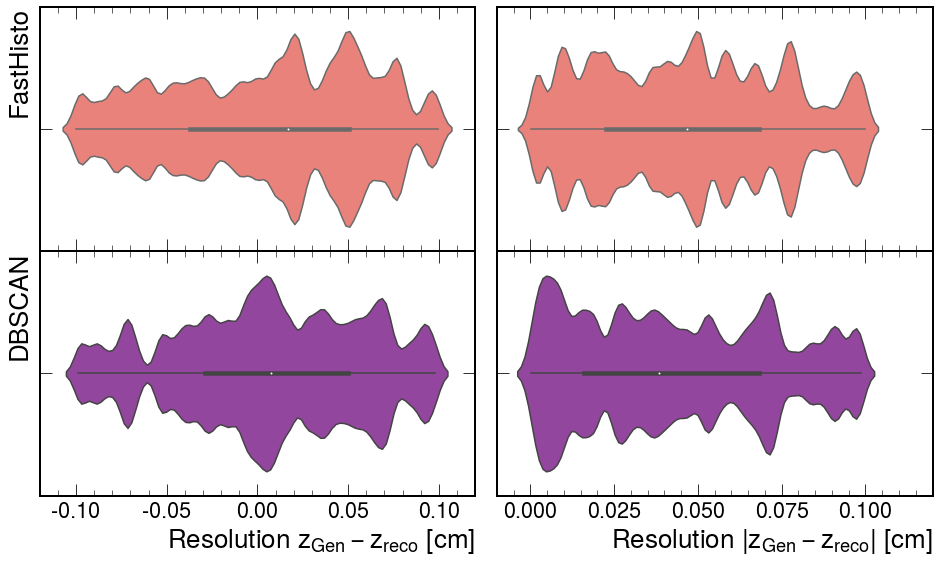

In [141]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

sns.violinplot(
    x=resolution.loc[np.abs(resolution["fasthisto"]) < 0.1, "fasthisto"],
    ax=ax[0, 0],
    color="#FA7268",
)
sns.violinplot(
    x=resolution.loc[np.abs(resolution["dbscan"]) < 0.1, "dbscan"],
    ax=ax[1, 0],
    color="#9E37AD",
)
plt.subplots_adjust(hspace=0)
ax[1, 0].set_xlabel(r"Resolution $z_{Gen} - z_{reco}$ [cm]")
sns.violinplot(
    x=np.abs(resolution.loc[np.abs(resolution["fasthisto"]) < 0.1, "fasthisto"]),
    ax=ax[0, 1],
    color="#FA7268",
)
sns.violinplot(
    x=np.abs(resolution.loc[np.abs(resolution["dbscan"]) < 0.1, "dbscan"]),
    ax=ax[1, 1],
    color="#9E37AD",
)
plt.subplots_adjust(hspace=0, wspace=0.05)
ax[1, 0].set_xlabel(r"Resolution $z_{Gen} - z_{reco}$ [cm]")
ax[0, 0].set_xlim(-0.12, 0.12)
ax[1, 0].set_xlim(-0.12, 0.12)
ax[0, 1].set_xlim(-0.01, 0.12)
ax[1, 1].set_xlim(-0.01, 0.12)
ax[1, 1].set_xlabel(r"Resolution $|z_{Gen} - z_{reco}|$ [cm]")
ax[0, 0].set_ylabel("FastHisto")
ax[1, 0].set_ylabel("DBSCAN")

Text(1, 0, 'Resolution $|z_{Gen} - z_{reco}|$ [cm]')

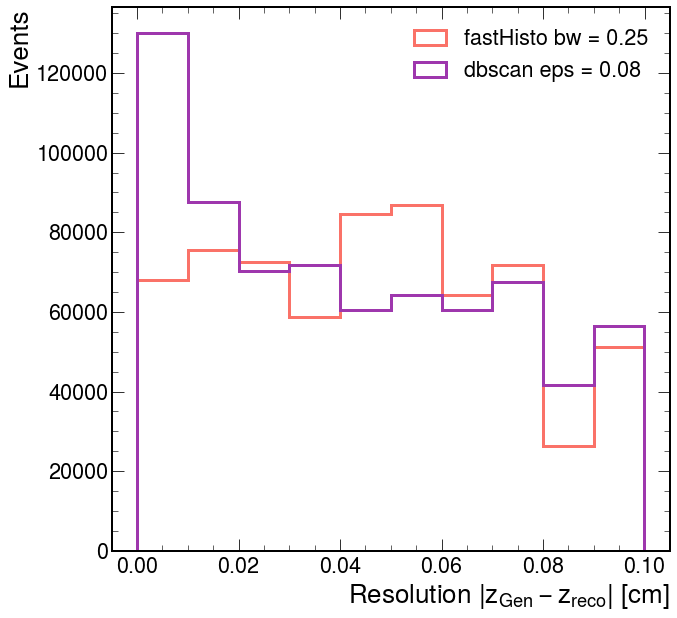

In [160]:
mask_fastHisto = np.abs(resolution["fasthisto"]) < 0.1
mask_dbscan = np.abs(resolution["dbscan"]) < 0.1


_, be, _ = plt.hist(
    np.abs(resolution.loc[mask_fastHisto, "fasthisto"].values),
    histtype="step",
    bins=10,
    label="fastHisto bw = 0.25",
    color="#FA7268",
    lw=3
)
_, _, _ = plt.hist(
    np.abs(resolution.loc[mask_dbscan, "dbscan"].values),
    histtype="step",
    bins=be,
    label="dbscan eps = 0.08",
    color="#9E37AD",
    lw=3
)
plt.legend()
plt.ylabel('Events')
plt.xlabel(r'Resolution $|z_{Gen} - z_{reco}|$ [cm]')

# Resolution of FastHisto and DBSCAN as a function of $z_{0}$

In [142]:
from scipy.stats import iqr

In [145]:
def pv_resolution_z0(
    z0_gen: np.array, z0_reco: np.array, bins: np.array, ylim: list = [0, 0.5], use_iqr=True
):

    mean_resolution = np.zeros(bins.shape[0] - 1)
    error_resolution = np.zeros(bins.shape[0] - 1)
    mask_true = np.abs(z0_gen - z0_reco) < 0.1
    for i, _ in enumerate(bins):
        if i == bins.shape[0] - 1:
            break
        mask = (z0_gen > bins[i]) & (z0_gen < bins[i + 1])
        resolution = np.abs(z0_gen[mask & mask_true] - z0_reco[mask & mask_true])

        mean_resolution[i] = np.mean(resolution)
        if use_iqr:
            error_resolution[i] = iqr(resolution)
        else:
            error_resolution[i] = np.std(resolution)

    x = 0.5 * (bins[1:] + bins[:-1])
    error_x = 0.5 * (bins[1:] - bins[:-1])
    
    return {"x": x, "error_x": error_x, "res": mean_resolution, "error_res": error_resolution}

Text(0, 1, '$|z_{Gen} - z_{reco}|$ [cm]')

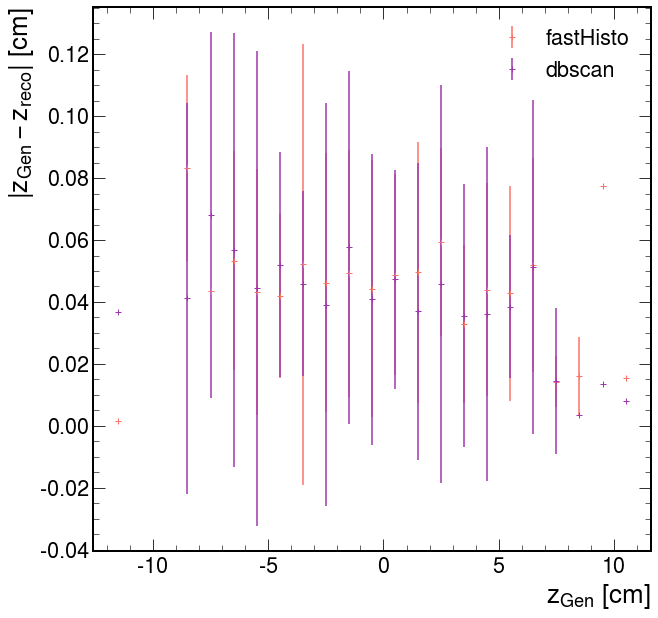

In [152]:
models = ["z0_fastHisto_0.25", "z0_dbscan_e0.08_min_2"]


results_fh = pv_resolution_z0(
    histo_results["z0_gen"], histo_results["z0_fastHisto_0.25"], bins=be_eff
)
results_db = pv_resolution_z0(
    dbscan_results["z0_gen"], dbscan_results["z0_dbscan_e0.08_min_2"], bins=be_eff
)

plt.errorbar(
    results_fh["x"],
    results_fh["res"],
    yerr=results_fh["error_res"],
    fmt="+",
    color = '#FA7268',
    label="fastHisto",
)
plt.errorbar(
    results_db["x"],
    results_db["res"],
    yerr=results_db["error_res"],
    fmt="+",
    label="dbscan",
    color="#9E37AD",
)
plt.legend()
plt.xlabel(r"$z_{Gen}$ [cm]")
plt.ylabel(r"$|z_{Gen} - z_{reco}|$ [cm]")

# DEBUG  ZONE

### Debugging jumpyness

In [309]:
def pv_efficiency_z0_2(
    z0_gen: np.array, z0_reco: np.array, bins: np.array, error_type: str = "clopper"
):

    eff = np.zeros(bins.shape[0] - 1)
    if error_type == "clopper":
        error_y = np.zeros((bins.shape[0] - 1, 2))
    else:
        error_y = np.zeros(bins.shape[0] - 1)

    for i, _ in enumerate(bins):
        if i == bins.shape[0] - 1:
            break
        mask = (z0_gen > bins[i]) & (z0_gen < bins[i + 1])
        mask_true = np.abs(z0_gen - z0_reco) < 0.1
        n = z0_gen[mask].shape[0]

        k = z0_reco[mask & mask_true].shape[0]
        eff[i] = k / (n)
        if error_type == "clopper":
            ci_low, ci_upp = proportion_confint(k, n, method="beta")
            error_y[i, 0] = ci_low
            error_y[i, 1] = ci_upp
        else:
            error_y[i] = binominal_error(k, (n + 0.0001))

    x = 0.5 * (bins[1:] + bins[:-1])
    error_x = 0.5 * (bins[1:] - bins[:-1])

    return {"x": x, "error_x": error_x, "eff": 100 * eff, "error_y": error_y}

In [260]:
dbscan_results.shape

(952812, 10)

950k Primary vertices, so stat's a plenty

In [262]:
dbscan_results.columns

Index(['z0_gen', 'z0_dbscan_e0.01_min_2', 'z0_dbscan_e0.03_min_2',
       'z0_dbscan_e0.05_min_2', 'z0_dbscan_e0.06_min_2',
       'z0_dbscan_e0.08_min_2', 'z0_dbscan_e0.1_min_2',
       'z0_dbscan_e0.15_min_2', 'z0_dbscan_e0.2_min_2',
       'z0_dbscan_e0.25_min_2'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of $z_{0}$ generated and the matched DBSCAN results')

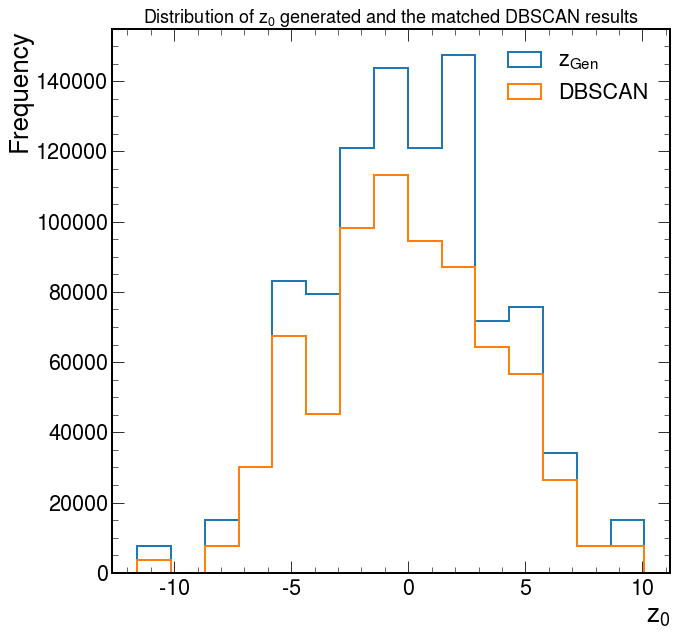

In [283]:
mask_matched = (np.abs(dbscan_results['z0_gen'] - dbscan_results['z0_dbscan_e0.08_min_2'])) < 0.1

_, be, _ = plt.hist(
    dbscan_results["z0_gen"].values, bins=15, histtype="step", lw=2, label=r"$z_{Gen}$"
)
_ = plt.hist(
    dbscan_results.loc[mask_matched, "z0_dbscan_e0.08_min_2"].values,
    bins=be,
    histtype="step",
    lw=2,
    label="DBSCAN",
)
plt.legend()
plt.xlabel(r'$z_{0}$')
plt.ylabel('Frequency')
plt.title('Distribution of $z_{0}$ generated and the matched DBSCAN results', fontsize=18)

This shows the distribution of $z_{0}$ that was generated, and the same distribution of DBSCAN that was successfully matched to the generated z0

Text(0.5, 1.0, 'Distribution of $z_{0}$ generated and the matched DBSCAN results')

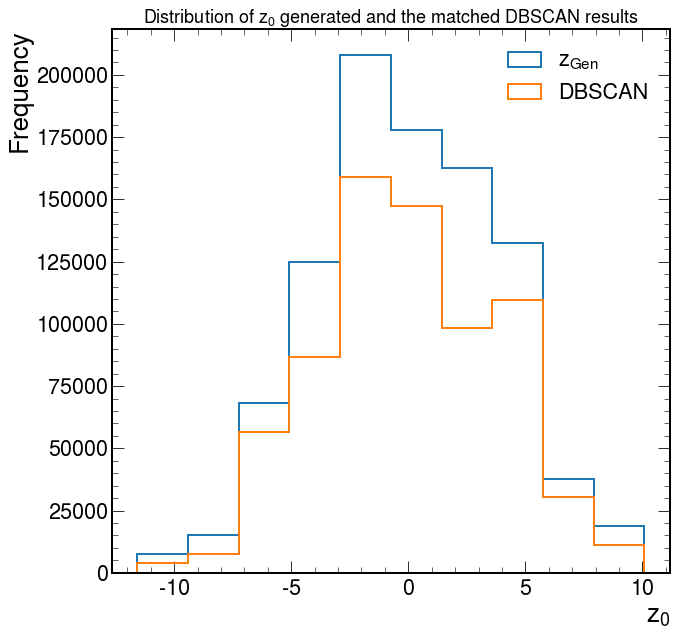

In [293]:
mask_matched = (np.abs(dbscan_results['z0_gen'] - dbscan_results['z0_dbscan_e0.08_min_2'])) < 0.1

_, be, _ = plt.hist(
    dbscan_results["z0_gen"].values, bins=10, histtype="step", lw=2, label=r"$z_{Gen}$"
)
_ = plt.hist(
    dbscan_results.loc[mask_matched, "z0_dbscan_e0.08_min_2"].values,
    bins=be,
    histtype="step",
    lw=2,
    label="DBSCAN",
)
plt.legend()
plt.xlabel(r'$z_{0}$')
plt.ylabel('Frequency')
plt.title('Distribution of $z_{0}$ generated and the matched DBSCAN results', fontsize=18)

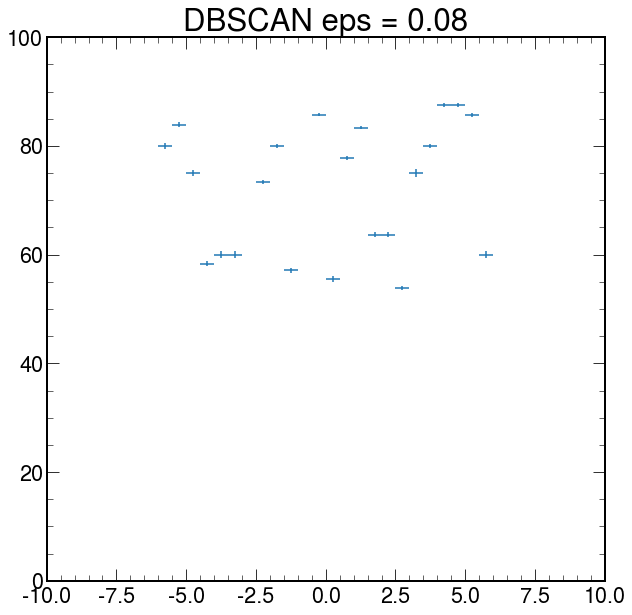

In [311]:
start, stop, step = -6, 6, 0.5
be_eff = np.arange(start, stop + step, step)
_results = pv_efficiency_z0_2(
    dbscan_results["z0_gen"], dbscan_results[f"z0_dbscan_e0.08_min_2"], be_eff,error_type= 'clopper'
)

lower_error = _results['eff'] - 100 * _results['error_y'][:,0]
upper_error = 100 * _results['error_y'][:, 1] - _results['eff']

plt.errorbar(
    _results["x"],
    _results["eff"],
            xerr=_results["error_x"],
            yerr=[lower_error, upper_error],
    ls='none',
    label=f"DBSCAN eps = 0.08",
)
plt.xlim(-10, 10)
plt.ylim(0, 100)
plt.title(f'DBSCAN eps = 0.08')
j+=1
plt.subplots_adjust(wspace=0)

In [381]:
def pv_efficiency_z0_bin_plots(
    z0_gen: np.array, z0_reco: np.array, bins: np.array, error_type: str = "clopper"
):

    eff = np.zeros(bins.shape[0] - 1)
    if error_type == "clopper":
        error_y = np.zeros((bins.shape[0] - 1, 2))
    else:
        error_y = np.zeros(bins.shape[0] - 1)

    fig, ax = plt.subplots(bins.shape[0] - 1, 1, figsize=(8, 6*bins.shape[0]-1))
    x = 0.5 * (bins[1:] + bins[:-1])
    
    
    for i, _ in enumerate(bins):
        if i == bins.shape[0] - 1:
            break
        mask = (z0_gen > bins[i]) & (z0_gen < bins[i + 1])
        mask_true = np.abs(z0_gen - z0_reco) < 0.1
        n = z0_gen[mask].shape[0]

        k = z0_gen[mask & mask_true].shape[0]
#         print("k: ", k, "\t n: ",n)
        try:
            eff[i] = k / (n)
        except ZeroDivisionError:
            eff[i] = 1
        
        #h, h_bins, _ = ax[i].hist(z0_gen[mask], histtype="step", bins=10, label="gen")
        
        h, h_bins = np.histogram(z0_gen[mask],bins=10)
        
        x_bins = 0.5 * (h_bins[1:] + h_bins[:-1])
        error_x = 0.5 * (h_bins[1:] - h_bins[:-1])
        low_bin = round(float(bins[i]),1)
        upp_bin = round(float(bins[i+1]),1)
        ax[i].errorbar(x_bins, h, xerr=error_x, yerr=np.sqrt(h), ls='none',fmt='k+', label = 'gen')
        
        ax[i].hist(z0_reco[mask & mask_true], bins=h_bins, label="reco", histtype="step", lw=2)
        print(f"Bin thresholds: {low_bin} < z0 < {upp_bin}, Eff: {round(100*eff[i],1)} (%)")
        print("k_hist: ", np.histogram(z0_gen[mask & mask_true].values, bins =h_bins)[0]) 
        print("n_hist: ", h)
        print("\n")
        ax[i].set_title(f"Bin thresholds: {low_bin} < $z_{0}$ < {upp_bin}, Eff: {round(100*eff[i],1)} (%)", fontsize = 12)
        ax[i].legend(bbox_to_anchor=(1.04, 1), loc='upper left',frameon=True)


        if error_type == "clopper":
            ci_low, ci_upp = proportion_confint(k, n, method="beta")
            error_y[i, 0] = ci_low
            error_y[i, 1] = ci_upp
        else:
            error_y[i] = binominal_error(k, (n + 0.0001))

    plt.savefig('bins.pdf', dpi = 500, bbox_inches='tight')

    return {"x": x, "error_x": error_x, "eff": 100 * eff, "error_y": error_y}

Bin thresholds: -10.0 < z0 < -9.0, Eff: 100.0 (%)
k_hist:  [0 0 0 0 0 0 0 0 0 0]
n_hist:  [0 0 0 0 0 0 0 0 0 0]


Bin thresholds: -9.0 < z0 < -8.0, Eff: 66.7 (%)
k_hist:  [   0 3781    0    0    0    0    0    0    0 3781]
n_hist:  [3781 3781    0    0    0    0    0    0    0 3781]


Bin thresholds: -8.0 < z0 < -7.0, Eff: 66.7 (%)
k_hist:  [   0    0    0    0    0    0    0    0    0 7562]
n_hist:  [3781    0    0    0    0    0    0    0    0 7562]


Bin thresholds: -7.0 < z0 < -6.0, Eff: 100.0 (%)
k_hist:  [3781    0 3781    0    0    0    0 3781 3781 7562]
n_hist:  [3781    0 3781    0    0    0    0 3781 3781 7562]


Bin thresholds: -6.0 < z0 < -5.0, Eff: 82.3 (%)
k_hist:  [7562    0 7562    0 7562    0 3781    0 3781 7085]
n_hist:  [11343     0  7562  3781  7562     0  3781     0  3781  7562]


Bin thresholds: -5.0 < z0 < -4.0, Eff: 65.0 (%)
k_hist:  [    0 11343     0     0 11343  3781  3781 11343  3781  3781]
n_hist:  [ 3781 11343     0     0 15124  3781  3781 18905  3781 1512

/mnt/storage/lborgna/condaenv/db-clustering/lib/python3.8/site-packages/statsmodels/stats/proportion.py:89: RuntimeWarning: invalid value encountered in double_scalars
  q_ = count * 1. / nobs


Bin thresholds: -2.0 < z0 < -1.0, Eff: 66.7 (%)
k_hist:  [ 3781  7562 15124  3781  3781  3775  3781  3781     0 15124]
n_hist:  [ 3781 11343 18905  3781  3781 18905  7562  3781     0 18905]


Bin thresholds: -1.0 < z0 < 0.0, Eff: 92.0 (%)
k_hist:  [18905 11343 11343     0     0  3781 15124  7562  7562 11343]
n_hist:  [18905 11343 11343     0     0  7562 15124 11343  7562 11343]


Bin thresholds: 0.0 < z0 < 1.0, Eff: 66.7 (%)
k_hist:  [ 3781     0  3781  3781 11343  3781  3781  7562     0  7562]
n_hist:  [ 3781  7562 11343  3781 11343  3781  3781  7562  3781 11343]


Bin thresholds: 1.0 < z0 < 2.0, Eff: 75.9 (%)
k_hist:  [ 3781 15124 11343 11343 15124 11343 11343     0  3781     0]
n_hist:  [ 7562 15124 11343 18905 15124 15124 11343     0  3781 11343]


Bin thresholds: 2.0 < z0 < 3.0, Eff: 58.3 (%)
k_hist:  [ 3781     0  7562  7562  3781  3781  3781  7562 11343  3781]
n_hist:  [ 7562     0 11343  7562  7562  7562  7562 11343 26467  3781]


Bin thresholds: 3.0 < z0 < 4.0, Eff: 78.6 (%)
k

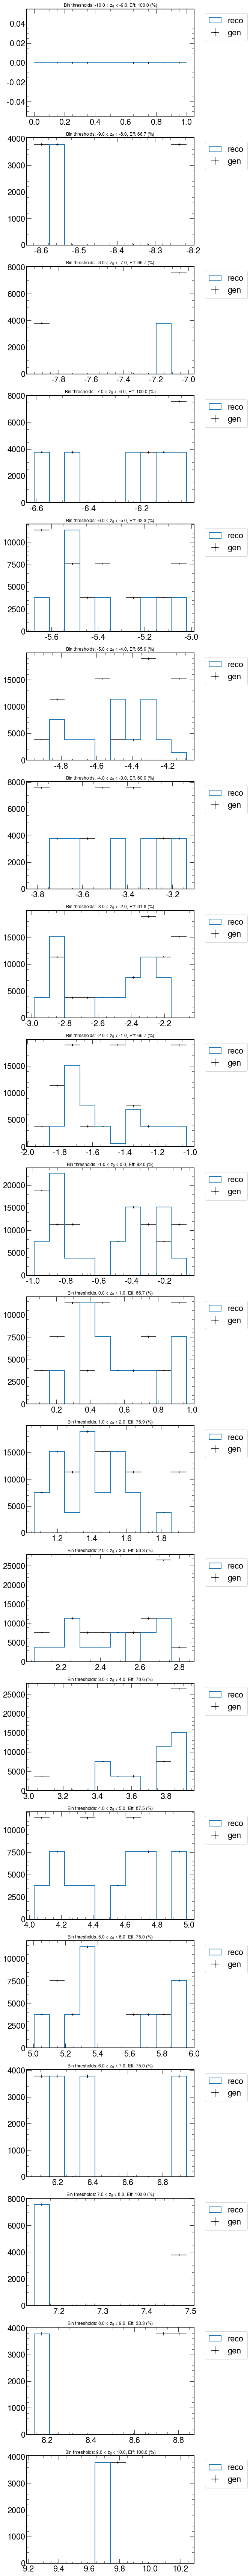

In [382]:
be_debug = np.arange(-10, 11,1)
_ = pv_efficiency_z0_bin_plots(
    dbscan_results["z0_gen"], dbscan_results[f"z0_dbscan_e0.08_min_2"], be_debug,error_type= 'clopper'
)